### **1. 환경 설정 및 함수 정의**

In [1]:
import torch
import torchaudio
import torchcrepe
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import Levenshtein
import os
from glob import glob
from sklearn.preprocessing import StandardScaler


In [2]:
# 데이터 경로 설정
pcm_files = sorted(glob("E:\KsponSpeech\original\KsponSpeech_01/**/*.pcm", recursive=True))[:10000]  # 30000개만 사용
txt_files = sorted(glob("E:\KsponSpeech\original\KsponSpeech_01/**/*.txt", recursive=True))[:10000]


In [3]:
# PCM 파일 로드 함수
def load_pcm(file_path, sr=16000):
    #raw_audio = np.fromfile(file_path, dtype=np.int16).astype(np.float32)  # PCM int16 > float32 변환
    raw_audio = torch.from_numpy(np.fromfile(file_path, dtype=np.int16).astype(np.float32))
    audio = raw_audio / torch.iinfo(torch.int16).max  # 정규화 (-1 ~ 1)

    # 샘플링 레이트 16000으로 고정
    orig_sr = 16000  # PCM 파일의 기본 SR이 16000이라고 가정
    if orig_sr != sr:
        resampler = torchaudio.transforms.Resample(orig_freq=orig_sr, new_freq=sr)
        audio = resampler(audio)

    return audio


In [4]:
print("🔹 처음 5개 파일:")
for i in range(min(5, len(pcm_files))):
    print(f"PCM: {pcm_files[i]}   TXT: {txt_files[i]}")
print("...")
print("🔹 마지막 5개 파일:")
for i in range(max(0, len(pcm_files) - 5), len(pcm_files)):
    print(f"PCM: {pcm_files[i]}   TXT: {txt_files[i]}")

🔹 처음 5개 파일:
PCM: E:\KsponSpeech\original\KsponSpeech_01\KsponSpeech_0001\KsponSpeech_000001.pcm   TXT: E:\KsponSpeech\original\KsponSpeech_01\KsponSpeech_0001\KsponSpeech_000001.txt
PCM: E:\KsponSpeech\original\KsponSpeech_01\KsponSpeech_0001\KsponSpeech_000002.pcm   TXT: E:\KsponSpeech\original\KsponSpeech_01\KsponSpeech_0001\KsponSpeech_000002.txt
PCM: E:\KsponSpeech\original\KsponSpeech_01\KsponSpeech_0001\KsponSpeech_000003.pcm   TXT: E:\KsponSpeech\original\KsponSpeech_01\KsponSpeech_0001\KsponSpeech_000003.txt
PCM: E:\KsponSpeech\original\KsponSpeech_01\KsponSpeech_0001\KsponSpeech_000004.pcm   TXT: E:\KsponSpeech\original\KsponSpeech_01\KsponSpeech_0001\KsponSpeech_000004.txt
PCM: E:\KsponSpeech\original\KsponSpeech_01\KsponSpeech_0001\KsponSpeech_000005.pcm   TXT: E:\KsponSpeech\original\KsponSpeech_01\KsponSpeech_0001\KsponSpeech_000005.txt
...
🔹 마지막 5개 파일:
PCM: E:\KsponSpeech\original\KsponSpeech_01\KsponSpeech_0010\KsponSpeech_009996.pcm   TXT: E:\KsponSpeech\original\KsponS

In [5]:
# 텍스트 전처리
import re

def clean_transcript(text):
    #  이중 전사 중 발음 스크립트 선택 ("(컴퓨터)/(컴퓨타)" → "컴퓨터")
    text = re.sub(r'\(([^)]+)\)/\(([^)]+)\)', r'(\2)', text)

    # 식별 불가 스크립트 제거 ("unk/나는" → "나는")
    text = re.sub(r'unk/\S+', '', text)

    # 노이즈 스크립트 제거 ("n/ o/ b/ u/ l/" 제거)
    text = re.sub(r'[nobul]/', '', text)

    # 특수문자 제거
    text = re.sub(r'[.,/!?;:\-()*+]', '', text)
    text = re.sub(r'\S+/', '', text)

    # 문장의 처음에 공백이 있거나 공백이 두 개 이상 이어져 있는 경우 공백을 하나로 정리
    text = re.sub(r'^\s+', '', text)  # 문장 처음의 공백 제거
    text = re.sub(r'\s+', ' ', text)  # 연속된 공백을 하나로 축소

    return text


In [28]:
def extract_features(audio, sr=16000):

    # MFCC 추출
    mfcc_transform = torchaudio.transforms.MFCC(
        sample_rate=sr,
        n_mfcc=13,
        melkwargs={
            "n_fft": 400,
            "hop_length": 160,
            "n_mels": 80
        }
    )
    mfcc = mfcc_transform(audio)

    # MFCC 정규화
    mfcc = normalize_mfcc(mfcc)

    # 스펙트로그램 변환
    spectorgram_transform = torchaudio.transforms.Spectrogram(
        n_fft=400,
        hop_length=160,
    )
    spectrogram = spectorgram_transform(audio)
    spectrogram_db = torchaudio.transforms.AmplitudeToDB()(spectrogram)

    # Pitch (음높이) 및 Energy (에너지)
    #pitch_transform = torchaudio.transforms.PitchShift(sr, n_steps=2)
    #pitch_values = pitch_transform(audio)
    pitch_values = 0  # 나중에 변경

    energy = torch.sqrt(torch.mean(audio**2, dim=-1))

    return mfcc, spectrogram_db, pitch_values, energy

def normalize_mfcc(mfcc):
    mean = torch.mean(mfcc, dim=1, keepdim=True)
    std = torch.std(mfcc, dim=1, keepdim=True)
    return (mfcc - mean) / (std + 1e-8)


In [12]:
# 데이터 로드 예시

audio_data = [load_pcm(file) for file in pcm_files[:10]]
texts = [open(txt, "r", encoding="cp949").read().strip() for txt in txt_files[:10]]

In [8]:
# 텍스트 전처리 출력 테스트
for text in texts:
  print(text)
  print(clean_transcript(text))

아/ 몬 소리야, 그건 또. b/
아 몬 소리야 그건 또 
나는 악습은 원래 없어진다+ 없어져야 된다고 생각하긴 했는데 근데 그/ 약간 필요악으로 하나 정도쯤은 있어야 되거든. 물 뜨러 가고.
나는 악습은 원래 없어진다 없어져야 된다고 생각하긴 했는데 근데 그 약간 필요악으로 하나 정도쯤은 있어야 되거든 물 뜨러 가고
b/ n/ 그래서 지호랑 계단 n/ 올라와서 b/ 막 위에 운동하는 기구 있대요. b/ 그서 그걸로 운동 할려구요. b/ n/
그래서 지호랑 계단 올라와서 막 위에 운동하는 기구 있대요 그서 그걸로 운동 할려구요 
뭐/ 정신과 병원도 그 약 타서 먹어보고, 그 한동안 연락이 안 된 적이 있었단 말이야. 그때가 언제였 언제였더라?
뭐 정신과 병원도 그 약 타서 먹어보고 그 한동안 연락이 안 된 적이 있었단 말이야 그때가 언제였 언제였더라
o/ b/ 그게 (0.1프로)/(영 점 일 프로) 가정의 아이들과 가정의 모습이야? b/
그게 영 점 일 프로 가정의 아이들과 가정의 모습이야 
그/ 친애하는 판사님께라는 법+ 법 관련 드라마 알고 있어?
그 친애하는 판사님께라는 법 법 관련 드라마 알고 있어
o/ 그래가지고 진짜 차 사야겠다 아니 뭐/ 차 안 되면 스쿠터라도 타야되겠다 막/ 그런 생각 들더라구 그래서 운전은 하는 게 좋은 거 같애 진짜 b/
그래가지고 진짜 차 사야겠다 아니 뭐 차 안 되면 스쿠터라도 타야되겠다 막 그런 생각 들더라구 그래서 운전은 하는 게 좋은 거 같애 진짜 
그래
그래
o/ 나도 몰라. 나 그/ (3G)/(쓰리 쥐)* 하나도 안 봤음. 어.
나도 몰라 나 그 쓰리 쥐 하나도 안 봤음 어
아/ 내일 나 알바하구나.
아 내일 나 알바하구나


In [27]:
# 예제 데이터로 특징 추출
mfcc, spectrogram_db, pitch_mean, energy = extract_features(audio_data[0])
print("Text: ", texts[0])
print("MFCC Raw:", mfcc)
print("MFCC Shape:", mfcc.shape)
print("Spectrogram Shape:", spectrogram_db.shape)
print("Pitch Mean:", pitch_mean)
print("Energy:", energy)

Text:  아/ 몬 소리야, 그건 또. b/
MFCC Raw: tensor([[-1.3372e+00, -1.2596e+00, -1.2233e+00,  ..., -1.0976e+00,
         -1.0822e+00, -1.2013e+00],
        [-1.3993e+00, -8.7625e-01, -8.3103e-01,  ..., -4.9156e-01,
         -5.2939e-01, -4.6778e-01],
        [ 5.7234e-01,  9.0763e-01,  5.2310e-01,  ...,  5.3884e-01,
          7.1024e-01,  1.2474e+00],
        ...,
        [ 1.5656e+00, -4.1436e-01, -2.1543e-01,  ...,  8.1051e-01,
          1.9598e-01,  5.7631e-04],
        [ 9.5651e-02, -1.0997e+00, -2.7613e-01,  ...,  4.5922e-01,
          1.1356e+00,  1.1126e+00],
        [ 1.3364e+00,  1.5560e+00,  1.7766e+00,  ...,  1.4341e+00,
          1.4761e+00,  2.3825e+00]])
MFCC Shape: torch.Size([13, 315])
Spectrogram Shape: torch.Size([201, 315])
Pitch Mean: 0
Energy: tensor(0.0379)


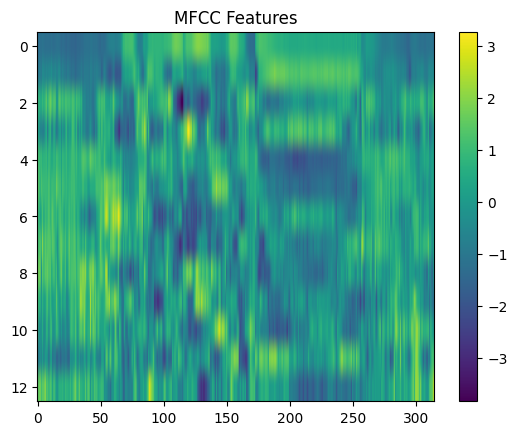

In [15]:
mfcc, _, _, _ = extract_features(audio_data[0])
plt.imshow(mfcc.squeeze(0).cpu().numpy(), cmap="viridis", aspect="auto")
plt.title("MFCC Features")
plt.colorbar()
plt.show()

### **2. 딥러닝 학습**

#### **2.1 데이터셋 클래스 정의**

In [53]:
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torchaudio.transforms as transforms

class SpeechDataset(Dataset):
    def __init__(self, pcm_files, txt_files, sr=16000):
        self.pcm_files = pcm_files
        self.txt_files = txt_files
        self.sr = sr
        self.tokenizer = self.create_tokenizer() # 토크나이저 추가

    def __len__(self):
        return len(self.pcm_files)

    def __getitem__(self, idx):
        try:
            audio = load_pcm(self.pcm_files[idx], self.sr)
            text = open(self.txt_files[idx], "r", encoding="cp949").read().strip()
            text = clean_transcript(text)
            mfcc, spec, pitch, energy = extract_features(audio, self.sr)
            tokenized_text = self.tokenizer.encode(text) # 텍스트 토큰화
            return mfcc, torch.tensor(tokenized_text, dtype=torch.long) # 토큰화된 텍스트 반환
        except Exception as e:
            print(f"Error loading file {self.pcm_files[idx]}: {e}")
            dummy_mfcc = torch.zeros(13, 100)  # 13 MFCC 계수, 100 프레임 (예제 값)
            dummy_text = torch.tensor([0], dtype=torch.long)  # 빈 텍스트
            return dummy_mfcc, dummy_text

    def create_tokenizer(self): # 간단한 토크나이저 생성
        char_to_int = {"<BLANK>": 0} # PAD, BLANK 토큰 할당
        int_to_char = {0: "<BLANK>"}

        chars = set()
        for txt_file in self.txt_files:
            with open(txt_file, "r", encoding="cp949") as f:
                text = f.read()
                text = clean_transcript(text)
                for char in text:
                    chars.add(char)

        for i, char in enumerate(sorted(list(chars))): # 문자-정수 매핑 생성
            char_to_int[char] = i + 1
            int_to_char[i + 1] = char

        return SimpleTokenizer(char_to_int, int_to_char)

class SimpleTokenizer: # 심플 토크나이저 클래스
    def __init__(self, char_to_int, int_to_char):
      self.char_to_int = {'<BLANK>': 0, **char_to_int}
      self.int_to_char = {0: '<BLANK>', **int_to_char}

    def encode(self, text):
        return [self.char_to_int.get(char, 0) for char in text]

    def decode(self, tokens):
        return "".join([self.int_to_char[token] for token in tokens if token != 0])

def collate_fn(batch):
    batch = [item for item in batch if item is not None]

    if not batch:
        return torch.empty(0), torch.empty(0), torch.empty(0)
    
    mfccs = [item[0].T for item in batch]
    texts = [item[1] for item in batch]

    mfccs_padded = pad_sequence(mfccs, batch_first=True, padding_value=0)  # [batch, T_max, 13]
    texts_padded = pad_sequence(texts, batch_first=True, padding_value=0) # text padding 추가
    text_lengths = torch.tensor([len(t) for t in texts if len(t) > 0], dtype=torch.long) # text 길이 tensor 추가

    return mfccs_padded, texts_padded, text_lengths # text 길이 반환

# 데이터셋 생성
dataset = SpeechDataset(pcm_files, txt_files)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)


In [73]:
for mfcc, text, text_lengths in dataloader:
    print(f"MFCC Shape: {mfcc.shape}")  # [batch, T, 13]이어야 정상

MFCC Shape: torch.Size([8, 1027, 13])
MFCC Shape: torch.Size([8, 1664, 13])
MFCC Shape: torch.Size([8, 955, 13])
MFCC Shape: torch.Size([8, 2592, 13])
MFCC Shape: torch.Size([8, 1166, 13])
MFCC Shape: torch.Size([8, 639, 13])
MFCC Shape: torch.Size([8, 793, 13])
MFCC Shape: torch.Size([8, 1064, 13])
MFCC Shape: torch.Size([8, 3006, 13])
MFCC Shape: torch.Size([8, 1582, 13])
MFCC Shape: torch.Size([8, 1349, 13])
MFCC Shape: torch.Size([8, 718, 13])
MFCC Shape: torch.Size([8, 1321, 13])
MFCC Shape: torch.Size([8, 1145, 13])
MFCC Shape: torch.Size([8, 1028, 13])
MFCC Shape: torch.Size([8, 1124, 13])
MFCC Shape: torch.Size([8, 1032, 13])
MFCC Shape: torch.Size([8, 1312, 13])
MFCC Shape: torch.Size([8, 1060, 13])
MFCC Shape: torch.Size([8, 1461, 13])
MFCC Shape: torch.Size([8, 2267, 13])
MFCC Shape: torch.Size([8, 1073, 13])
MFCC Shape: torch.Size([8, 1742, 13])
MFCC Shape: torch.Size([8, 1501, 13])


KeyboardInterrupt: 

In [30]:
# Save the dataset to a file
torch.save(dataset, 'data/speech_dataset.pth')


In [18]:
# Load the dataset back
dataset = torch.load('data/speech_dataset.pth', weights_only=False)


In [31]:
# 토큰화 사전 출력
print("Tokenization Dictionary:")
print(dataset.tokenizer.char_to_int)
print(dataset.tokenizer.int_to_char)

Tokenization Dictionary:
{'<BLANK>': 0, ' ': 1, 'A': 2, 'B': 3, 'C': 4, 'D': 5, 'E': 6, 'F': 7, 'G': 8, 'H': 9, 'I': 10, 'J': 11, 'K': 12, 'L': 13, 'M': 14, 'N': 15, 'O': 16, 'P': 17, 'R': 18, 'S': 19, 'T': 20, 'U': 21, 'V': 22, 'X': 23, 'Y': 24, 'a': 25, 'b': 26, 'c': 27, 'd': 28, 'e': 29, 'f': 30, 'g': 31, 'h': 32, 'i': 33, 'k': 34, 'l': 35, 'm': 36, 'n': 37, 'o': 38, 'p': 39, 'q': 40, 'r': 41, 's': 42, 't': 43, 'v': 44, 'x': 45, '가': 46, '각': 47, '간': 48, '갈': 49, '갉': 50, '감': 51, '갑': 52, '값': 53, '갓': 54, '갔': 55, '강': 56, '갖': 57, '같': 58, '갚': 59, '개': 60, '객': 61, '갠': 62, '갤': 63, '갬': 64, '갭': 65, '갱': 66, '갸': 67, '걀': 68, '걍': 69, '걔': 70, '걘': 71, '거': 72, '걱': 73, '건': 74, '걷': 75, '걸': 76, '검': 77, '겁': 78, '것': 79, '겄': 80, '겉': 81, '게': 82, '겐': 83, '겔': 84, '겠': 85, '겨': 86, '격': 87, '겪': 88, '견': 89, '결': 90, '겸': 91, '겹': 92, '겼': 93, '경': 94, '계': 95, '곗': 96, '고': 97, '곡': 98, '곤': 99, '곧': 100, '골': 101, '곪': 102, '곰': 103, '곱': 104, '곳': 105, '공': 106, '곶': 107

#### **2.2 모델 구축 및 학습**

In [32]:
print("PyTorch 버전:", torch.__version__)
print("CUDA 사용 가능 여부:", torch.cuda.is_available())
print("GPU 개수:", torch.cuda.device_count())
print("PyTorch CUDA: ", torch.version.cuda)

if torch.cuda.is_available():
    print("사용 가능한 GPU 목록:")
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")

print("현재 설정된 device:", torch.device("cuda" if torch.cuda.is_available() else "cpu"))


PyTorch 버전: 2.6.0+cu118
CUDA 사용 가능 여부: True
GPU 개수: 1
PyTorch CUDA:  11.8
사용 가능한 GPU 목록:
GPU 0: NVIDIA GeForce RTX 3070
현재 설정된 device: cuda


In [33]:
# Set Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Setting Device: ", device)

Setting Device:  cuda


In [76]:
import torch.nn as nn
import torch.optim as optim

class SpeechRecognitionModel(nn.Module):
    def __init__(self, input_dim=13, hidden_dim=256, output_dim=len(dataset.tokenizer.char_to_int)):
        super(SpeechRecognitionModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, x):
        #X shape: [batch, T, 13]
        x, _ = self.lstm(x)    # [batch, T(seq_len), input_size(13)]
        x = self.fc(x)
        x = torch.nn.functional.log_softmax(x, dim=2)

        if torch.isnan(x).any():
            print("Warning: NaN detected in model forward!")
        elif torch.isinf(x).any():
            print("Warning: Inf detected in model forward!")

        return x

    def reset_parameters(self):
        def init_weights(m):
            if isinstance(m, (nn.Linear, nn.LSTM)):
                m.reset_parameters()
        self.apply(init_weights)


# 모델 생성
model = SpeechRecognitionModel().to(device)
model.reset_parameters()
criterion = nn.CTCLoss(blank=0, zero_infinity=True)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)


In [77]:
#torch.autograd.set_detect_anomaly(True)
print("Starting Training")
# 학습 루프 (10 Epoch)
for epoch in range(10):
    total_loss = 0
    i = 0
    for mfcc, text, text_lengths in dataloader:
        i += 1
        mfcc = mfcc.to(device)
        text = text.to(device)
        text_lengths = text_lengths.to(device)

        # 빈 텍스트 샘플 제거
        valid_mask = torch.tensor([t[t != 0].numel() > 0 for t in text], dtype=torch.bool)
        if not valid_mask.any():
            print("Warning: All target sequences are empty! Skipping batch.")
            continue

        text = text[valid_mask]
        text_lengths = text_lengths[valid_mask]

        if torch.isnan(mfcc).any() or torch.isinf(mfcc).any():
          print("NaN/Inf detected in input MFCC! Skipping batch.")
          continue
        elif torch.isnan(text).any() or torch.isinf(text).any():
          print("NaN/Inf detected in input text! Skipping batch.")
          continue
        elif torch.isnan(text_lengths).any() or torch.isinf(text_lengths).any():
          print("NaN/Inf detected in input text_lengths! Skipping batch.")
          continue

        # 옵티마이저 Gradient 초기화
        optimizer.zero_grad()

        # 모델에 MFCC 입력하여 출력 얻기 (Forward)
        outputs = model(mfcc)
        outputs = outputs.permute(1, 0, 2)  # (T, N, C)로 변환
        
        # 모델 출력 NaN 체크
        if torch.isnan(outputs).any() or torch.isinf(outputs).any():
            print("Warning: NaN/Inf detected in model outputs! Skipping batch.")
            continue

        # 입력 길이 설정 (모델 출력 길이 기준)
        #input_lengths = torch.tensor([outputs.size(0)] * outputs.size(1), dtype=torch.long).to(device)
        input_lengths = torch.full((outputs.size(1),), outputs.size(0), dtype=torch.long).to(device)
        # 출력 시퀀스 설정
        target_lengths = torch.tensor([len(t[t != 0]) for t in text], dtype=torch.long).to(device)

        targets = torch.cat([t[t != 0] for t in text]).to(device)

        # NaN 방지 체크
        if(input_lengths < target_lengths).any():
          print(f"Error: Some input_lengths ({input_lengths} are shorter than target_lengths ({target_lengths})!)")
          continue


        # CTC Loss 계산 (입력: 모델 출력, 타겟: 정답 텍스트, 입력 길이, 출력 길이)
        loss = criterion(outputs, targets, input_lengths, target_lengths)

        # CTC Loss NaN 체크
        if torch.isnan(loss).any() or torch.isinf(loss).any():
            print("Warning: NaN/Inf detected in loss computation!")
            continue

        # 역전파(Gradient 계산)
        loss.backward() 

        # Gradient Clipping 적용
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # 가중치 업데이트
        optimizer.step()

        total_loss += loss.item()

        # Print Count
        if (epoch + 1) % 1 == 0 and i % 10 == 0:
            print(f"Epoch [{epoch+1}/{10}], Step [{i}/{len(dataloader)}], Loss: {loss.item():.4f}")

    scheduler.step()

    # Epoch마다 Loss 출력
    print(f"Epoch {epoch+1}: Avg Loss = {total_loss / len(dataloader):.4f} Current Loss = {loss.item():.4f}")


Starting Training
Epoch [1/10], Step [10/1250], Loss: 607.4986
Epoch [1/10], Step [20/1250], Loss: 644.2517
Epoch [1/10], Step [30/1250], Loss: 799.6191
Epoch [1/10], Step [40/1250], Loss: 360.5333
Epoch [1/10], Step [50/1250], Loss: 246.9906
Epoch [1/10], Step [60/1250], Loss: 401.8241
Epoch [1/10], Step [70/1250], Loss: 32.2568
Epoch [1/10], Step [80/1250], Loss: 17.7345
Epoch [1/10], Step [90/1250], Loss: 6.0817
Epoch [1/10], Step [100/1250], Loss: 7.0305
Epoch [1/10], Step [110/1250], Loss: 5.5945
Epoch [1/10], Step [120/1250], Loss: 5.4751
Epoch [1/10], Step [130/1250], Loss: 5.1227
Epoch [1/10], Step [140/1250], Loss: 4.9977
Epoch [1/10], Step [150/1250], Loss: 5.0609
Epoch [1/10], Step [160/1250], Loss: 5.2890
Epoch [1/10], Step [170/1250], Loss: 5.2344
Epoch [1/10], Step [180/1250], Loss: 4.7777
Epoch [1/10], Step [190/1250], Loss: 5.5446
Epoch [1/10], Step [200/1250], Loss: 5.1239
Epoch [1/10], Step [210/1250], Loss: 6.2890
Epoch [1/10], Step [220/1250], Loss: 6.9957
Epoch [1/

In [78]:
# 전체 모델 저장
torch.save(model, 'data/speech_model_full.pth')
torch.save(model.state_dict(), 'data/speech_model.pth')

In [79]:
# 학습 진행 상태 저장
checkpoint = {
    'epoch': epoch,  # 마지막 학습한 에포크
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss.item()
}
torch.save(checkpoint, 'data/speech_checkpoint.pth')

In [ ]:
"""
# 학습 진행 상태 불러오기
checkpoint = torch.load('/content/drive/MyDrive/speech_checkpoint.pth')

# 모델, 옵티마이저 로드
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# 마지막 에포크 번호 확인
start_epoch = checkpoint['epoch'] + 1
print(f"Resuming training from epoch {start_epoch}")
"""

#### **2.4 평가**

In [188]:
import Levenshtein

def evaluate_model_tmp(model, audio_file, text_file, tokenizer, sr=16000):
    """
    학습된 모델을 활용하여 새로운 음성 파일과 텍스트 파일을 비교하여 정확도를 평가하는 함수.
    """

    # 음성 파일 로드 및 특징 추출
    try:
        audio = load_pcm(audio_file, sr)  # PCM 파일 로드
        mfcc, _, _, _ = extract_features(audio, sr)  # MFCC 추출
        mfcc = mfcc.unsqueeze(0).permute(0,2,1).to(device)  # 배치 차원 추가 및 GPU로 이동 0/2/1
        print("Shape: ", mfcc.shape)
    except Exception as e:
        print(f"Error loading audio file {audio_file}: {e}")
        return None

    # 모델 추론
    model.eval()
    with torch.no_grad():
        output = model(mfcc) # output shape : (batch, T, output_dim)

    print("Output Shape: ", output.shape)

    # CTC 디코딩 (가장 높은 확률의 인덱스를 선택)
    predicted_indices = torch.argmax(output, dim=2)  # (N, T) 형태
    predicted_tokens = [token.item() for token in predicted_indices[0]]

    print("Predicted Tokens: ", predicted_tokens)

    # 중복 제거 (CTC 특성상 같은 문자가 연속적으로 나타나는 경우가 많음)
    def ctc_decode(tokens):
        decoded = []
        prev_token = None
        for token in tokens:
            if token != prev_token and token != 0:  # BLANK 토큰(0) 무시
                decoded.append(token)
            prev_token = token
        return decoded

    predicted_tokens = ctc_decode(predicted_tokens)
    predicted_text = tokenizer.decode(predicted_tokens)  # 토큰을 문자로 변환

    # 정답 텍스트 로드 및 토큰 변환
    with open(text_file, "r", encoding="cp949") as f:
        ground_truth_text = f.read().strip()
        ground_truth_text = clean_transcript(ground_truth_text)

    # WER (Word Error Rate) 및 CER (Character Error Rate) 계산
    def calculate_wer(ref, hyp):
        ref_words = ref.split()
        hyp_words = hyp.split()
        return Levenshtein.distance(ref_words, hyp_words) / max(len(ref_words), 1)

    def calculate_cer(ref, hyp):
        return Levenshtein.distance(ref, hyp) / max(len(ref), 1)

    wer = calculate_wer(ground_truth_text, predicted_text)
    cer = calculate_cer(ground_truth_text, predicted_text)

    # 결과 출력
    print("\n📌 Evaluation Result")
    print(f"🔹 Reference Text  : {ground_truth_text}")
    print(f"🔹 Predicted Text  : {predicted_text}")
    print(f"✅ WER: {wer:.4f}, CER: {cer:.4f}")

    return {"predicted_text": predicted_text, "wer": wer, "cer": cer}

# 추가 함수 (load_pcm, clean_transcript, extract_features, normalize_mfcc, SimpleTokenizer)는 기존 코드를 사용

In [189]:
#실제 평가
num = 9812

result = evaluate_model_tmp(model, pcm_files[num], txt_files[num], dataset.tokenizer)

print(result)

Shape:  torch.Size([1, 623, 13])
Output Shape:  torch.Size([1, 623, 1395])
Predicted Tokens:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1033, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 72, 1, 0, 0, 0, 0

In [176]:
import Levenshtein

def evaluate_model(model, pcm_file, txt_file, device=device):
    """
    평가용 함수: 학습된 모델을 사용하여 단일 PCM 파일에 대한 음성 인식을 수행하고 정확도를 평가합니다.
    
    Args:
        model (str): 저장된 모델 파일 경로
        pcm_file (str): 평가할 PCM 파일 경로
        txt_file (str): 평가할 PCM 파일의 정답 텍스트 파일 경로
        device (str): 사용할 디바이스 ('cuda' or 'cpu')
    
    Returns:
        dict: 평가 결과를 담은 딕셔너리 (예측 텍스트, 정답 텍스트, CER, WER 등)
    """
    # 모델 로드
    try:       
        # 모델 
        model.eval()
        print(f"모델을 성공적으로 로드했습니다: {model}")
    except Exception as e:
        print(f"모델 로드 중 오류 발생: {e}")
        return {"error": f"모델 로드 실패: {e}"}
    
    # PCM 파일 로드
    try:
        audio = load_pcm(pcm_file)
        
        # 특성 추출
        mfcc, spec, pitch, energy = extract_features(audio)
        
        # 정답 텍스트 로드
        with open(txt_file, "r", encoding="cp949") as f:
            ground_truth = f.read().strip()
            ground_truth = clean_transcript(ground_truth)
        
        print(f"파일 로드 완료: {os.path.basename(pcm_file)}")
    except Exception as e:
        print(f"파일 로드 중 오류 발생: {e}")
        return {"error": f"파일 로드 실패: {e}"}
    
    # 추론 실행
    with torch.no_grad():
        try:
            # MFCC 데이터 준비 (배치 차원 추가)
            mfcc = mfcc.T.unsqueeze(0).to(device)  # [1, T, 13]
            
            # 모델 추론
            outputs = model(mfcc)  # [1, T, num_classes]
            
            # 디코딩 (CTC 디코딩 - Greedy Search)
            pred_indices = torch.argmax(outputs, dim=2).cpu().numpy()[0]  # 가장 확률 높은 토큰 인덱스
            
            # 중복 제거 (CTC collapse)
            collapsed_indices = []
            prev_idx = -1
            for idx in pred_indices:
                if idx != prev_idx and idx != 0:  # 0은 blank 토큰
                    collapsed_indices.append(idx)
                prev_idx = idx
            
            # 텍스트로 변환
            predicted_text = dataset.tokenizer.decode(collapsed_indices)
            
            print(f"추론 완료: '{predicted_text}'")
        except Exception as e:
            print(f"추론 중 오류 발생: {e}")
            return {"error": f"추론 실패: {e}"}
    
    # 평가 지표 계산
    # 1. Character Error Rate (CER)
    cer = Levenshtein.distance(predicted_text, ground_truth) / max(len(ground_truth), 1)
    
    # 2. Word Error Rate (WER)
    pred_words = predicted_text.split()
    gt_words = ground_truth.split()
    wer = Levenshtein.distance(" ".join(pred_words), " ".join(gt_words)) / max(len(gt_words), 1)
    
    # 3. 정확도 (일치율)
    accuracy = 1.0 if predicted_text == ground_truth else 0.0
    
    # 결과 정리
    result = {
        "predicted_text": predicted_text,
        "ground_truth": ground_truth,
        "cer": cer,
        "wer": wer,
        "accuracy": accuracy,
        "cer_percentage": f"{cer*100:.2f}%",
        "wer_percentage": f"{wer*100:.2f}%",
    }
    
    print(f"평가 결과:")
    print(f"  예측 텍스트: '{predicted_text}'")
    print(f"  정답 텍스트: '{ground_truth}'")
    print(f"  문자 오류율(CER): {result['cer_percentage']}")
    print(f"  단어 오류율(WER): {result['wer_percentage']}")
    
    return result


In [166]:
num = 100
accuracy = evaluate_model(model, pcm_files[num], txt_files[num], device)

모델을 성공적으로 로드했습니다: SpeechRecognitionModel(
  (lstm): LSTM(13, 256, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=512, out_features=1395, bias=True)
)
파일 로드 완료: KsponSpeech_000101.pcm
추론 완료: '가   고'
평가 결과:
  예측 텍스트: '가   고'
  정답 텍스트: '근데 키가 크다니까 백팔십팔 그리고 몸'
  문자 오류율(CER): 76.19%
  단어 오류율(WER): 300.00%
